<h1><center>Analyzing User Retention</center></h1>

In [1]:
# Necessary libraries are being installed

import pandas as pd #Data Reading, Writing, Exploration, Cleaning
import numpy as np #Array Creation and operation
import matplotlib.pyplot as plt #plotting library
import seaborn as sns #data visualization library

from sklearn.model_selection import train_test_split #splitting datasets into training and testing sets
from sklearn.linear_model import LogisticRegression #classification algorithm
from sklearn.preprocessing import StandardScaler #used for standardizing features
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay #
from sklearn import metrics #provides various functions for evaluating the performance of machine learning models

from imblearn.over_sampling import RandomOverSampler #used for addressing class imbalance by oversampling the minority class
from imblearn.under_sampling import RandomUnderSampler #used for addressing class imbalance by undersampling the minority class
from imblearn.over_sampling import SMOTE #used to address class imbalance in machine learning datasets
from collections import Counter #used for counting occurrences of elements in a collection

from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

import warnings #To hide the warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Data Cleaning

In [2]:
df = pd.read_csv("UserRetentionData.csv")       # reading the data
df.shape

(2666, 20)

In [3]:
df.columns

Index(['Region', 'Tenure', 'Neighborhood', 'Trunk Calling Facility',
       'Voice Messaging', 'Number voice messages', 'Minutes Peak Hrs',
       'Calls Peak Hrs', 'Bill Peak Hrs', 'Minutes Off Peak', 'Calls Off Peak',
       'Bill Off Peak', 'Minutes Night', 'Calls Night', 'Bill Night',
       'Trunk Call Minutes', 'Trunk Calls', 'Trunk Call Bill',
       'Contact for Grievances/Changes', 'Acct Closed?'],
      dtype='object')

In [4]:
df[df.duplicated()]

,Region,Tenure,Neighborhood,Trunk Calling Facility,Voice Messaging,Number voice messages,Minutes Peak Hrs,Calls Peak Hrs,Bill Peak Hrs,Minutes Off Peak,Calls Off Peak,Bill Off Peak,Minutes Night,Calls Night,Bill Night,Trunk Call Minutes,Trunk Calls,Trunk Call Bill,Contact for Grievances/Changes,Acct Closed?


No duplicates rows are present.

In [5]:
df.isnull().sum()

Region                            0
Tenure                            0
Neighborhood                      0
Trunk Calling Facility            0
Voice Messaging                   0
Number voice messages             0
Minutes Peak Hrs                  0
Calls Peak Hrs                    0
Bill Peak Hrs                     0
Minutes Off Peak                  0
Calls Off Peak                    0
Bill Off Peak                     0
Minutes Night                     0
Calls Night                       0
Bill Night                        0
Trunk Call Minutes                0
Trunk Calls                       0
Trunk Call Bill                   0
Contact for Grievances/Changes    0
Acct Closed?                      0
dtype: int64

No null values were found

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Region                          2666 non-null   object 
 1   Tenure                          2666 non-null   int64  
 2   Neighborhood                    2666 non-null   int64  
 3   Trunk Calling Facility          2666 non-null   object 
 4   Voice Messaging                 2666 non-null   object 
 5   Number voice messages           2666 non-null   int64  
 6   Minutes Peak Hrs                2666 non-null   float64
 7   Calls Peak Hrs                  2666 non-null   int64  
 8   Bill Peak Hrs                   2666 non-null   float64
 9   Minutes Off Peak                2666 non-null   float64
 10  Calls Off Peak                  2666 non-null   int64  
 11  Bill Off Peak                   2666 non-null   float64
 12  Minutes Night                   26

In [7]:
df.Neighborhood = df.Neighborhood.astype('object')
df['Contact for Grievances/Changes'] = df['Contact for Grievances/Changes'].astype('object')
df['Trunk Calls'] = df['Trunk Calls'].astype('object')

### Exploratory Data Analysis and Data-Preprocessing

In [8]:
num_columns = df.select_dtypes(exclude='object').columns.tolist()
len(num_columns)

14

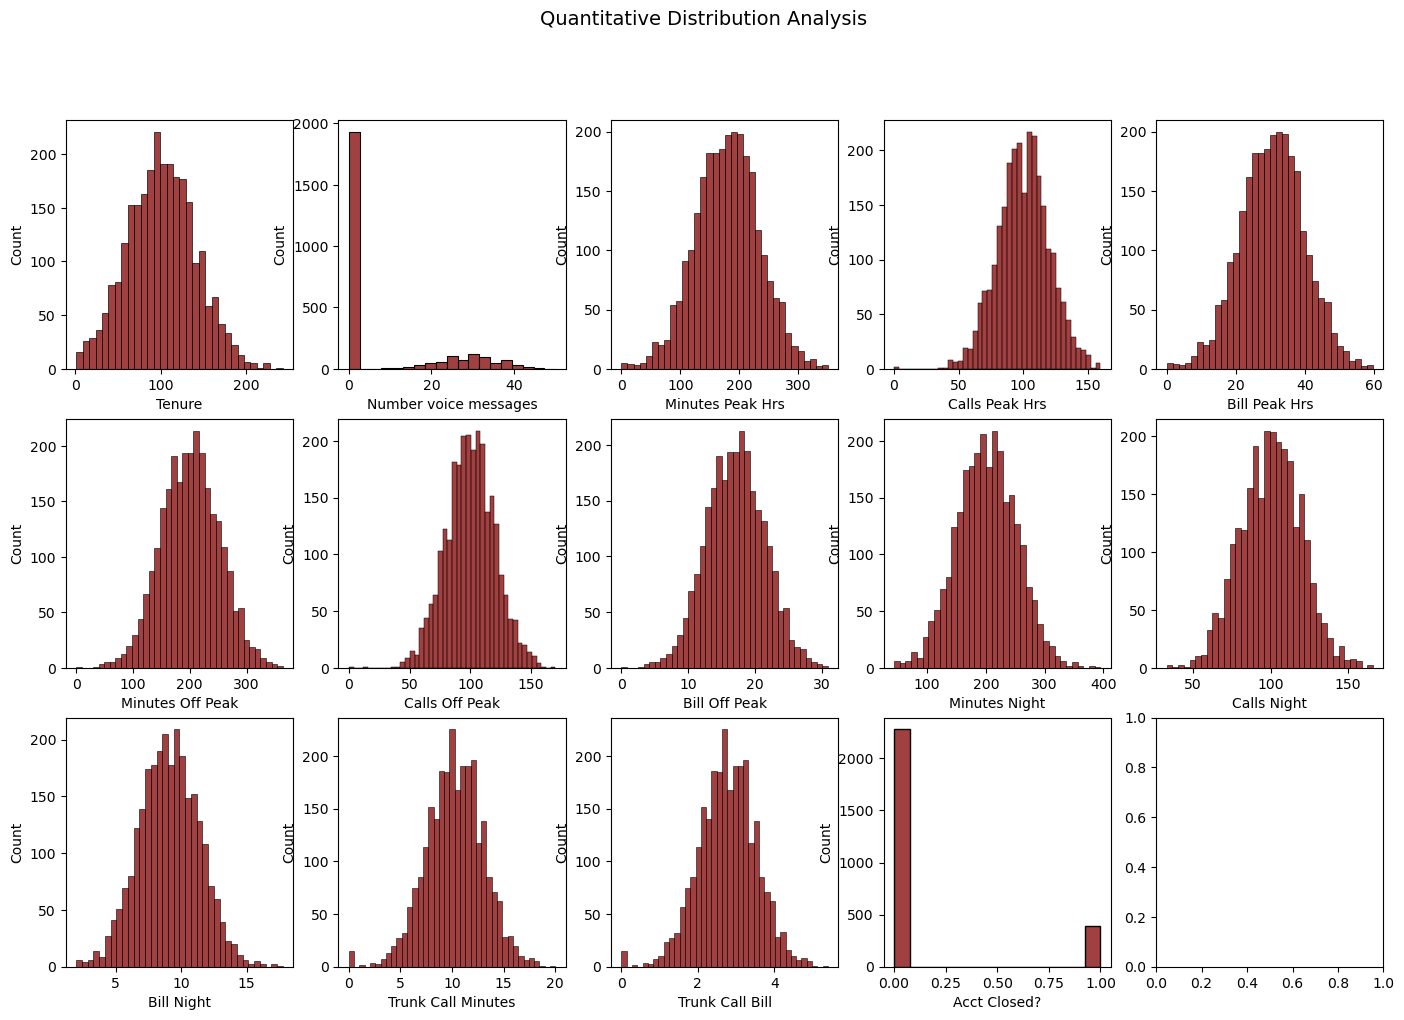

Tenure                   0.079023
Number voice messages    1.271774
Minutes Peak Hrs        -0.053106
Calls Peak Hrs          -0.128267
Bill Peak Hrs           -0.053087
Minutes Off Peak        -0.012665
Calls Off Peak          -0.065209
Bill Off Peak           -0.012629
Minutes Night            0.023362
Calls Night              0.010410
Bill Night               0.023318
Trunk Call Minutes      -0.224434
Trunk Call Bill         -0.224569
Acct Closed?             2.011470
dtype: float64

In [9]:
fig,axs = plt.subplots(3,5,figsize=(17,11))
i=1
j=1
fig.suptitle('Quantitative Distribution Analysis',fontsize=14)
for col in num_columns:
    sns.histplot(df[col],ax=axs[i-1][j-1],color='maroon')
    # axs[i-1][j-1].set_title(col)
    if (j%5 == 0): i+=1
    if j!=5: j=(j+1)
    else: j=1

plt.show()
df[num_columns].skew()

- Few Features are incorrectly termed as numerical. Such as Number voice messages and Acct Closed?
- Last feature is the target present as a boolean
- Numerical features appears to be normally distributed. But, there skewness values for only the numerical features are quite low
- Skewness for categorical features like Number voice messages and acct closed are irrelevant
- Minutes peak hrs is slightly negatively skewed. There is slight difference in the skewness of Minutes peak hrs and calls peak hrs. In calls peak hrs, we have values which are zero and so the skewness is comparatively less negative.
- We have scenerio where there is no calls during peak hrs and it might be because of public holiday or weekend.


In [10]:
df[num_columns].describe()

,Tenure,Number voice messages,Minutes Peak Hrs,Calls Peak Hrs,Bill Peak Hrs,Minutes Off Peak,Calls Off Peak,Bill Off Peak,Minutes Night,Calls Night,Bill Night,Trunk Call Minutes,Trunk Call Bill
count,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,2.764490
std,39.563974,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,0.752812
min,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000
25%,73.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,2.300000
50%,100.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,2.750000
75%,127.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,3.270000
max,243.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,5.400000


#### As the overall skewness for the numerical features are low and the above descriptive statistics of the same confirm this, not necessary to perform any transformations on these features. 


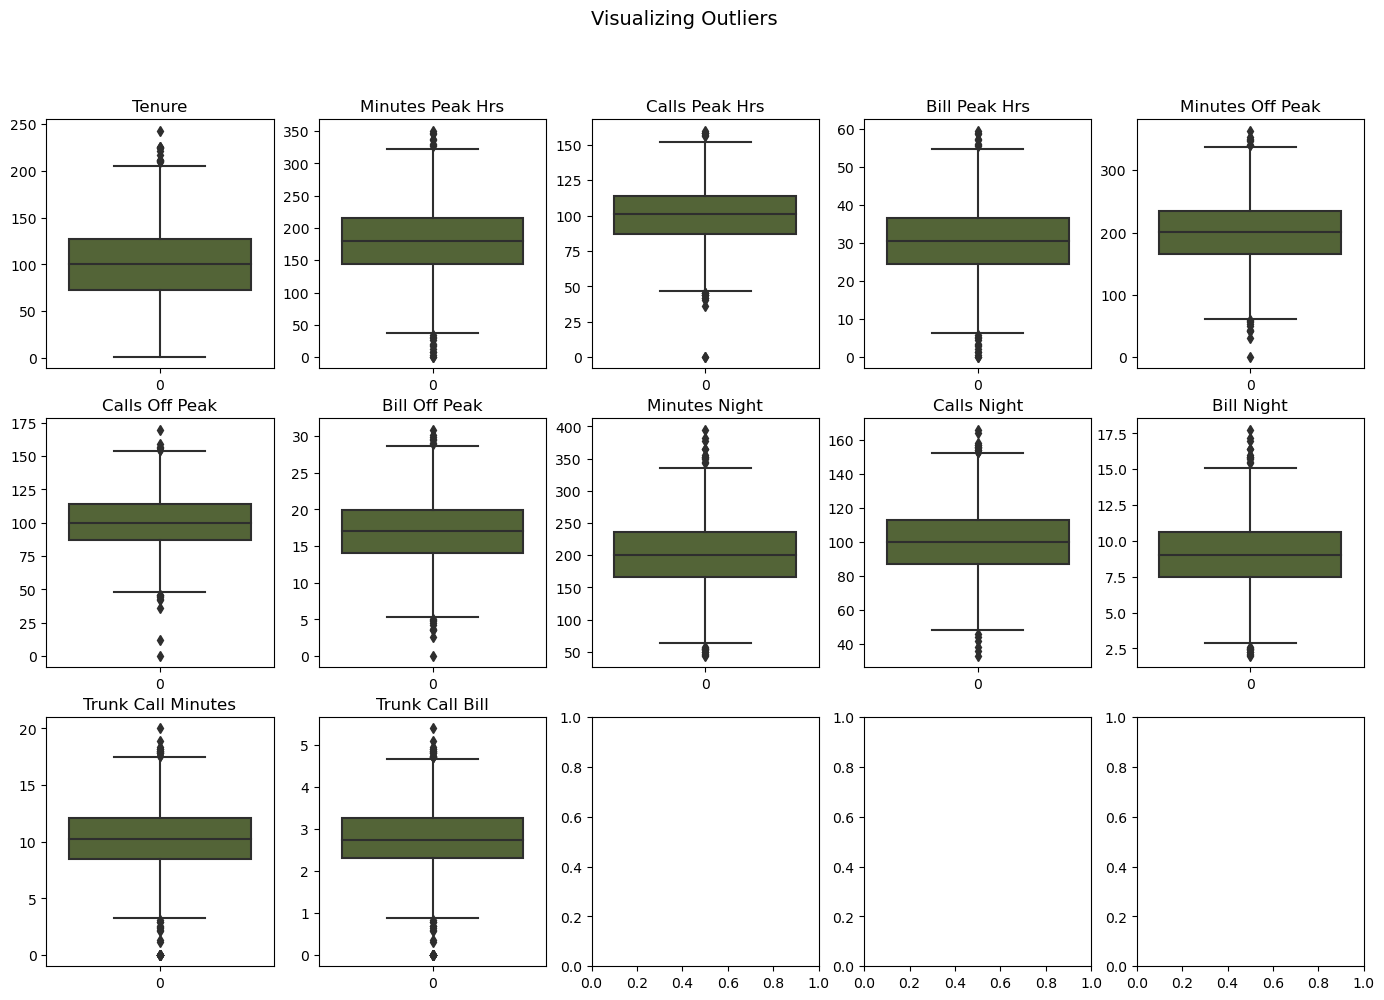

In [11]:
fig,axs = plt.subplots(3,5,figsize=(17,11))
i=1
j=1
fig.suptitle('Visualizing Outliers',fontsize=14)
for col in num_columns:
    if (col=='Number voice messages') | (col == 'Acct Closed?'):
        continue
    else:
        sns.boxplot(df[col],ax=axs[i-1][j-1],color='darkolivegreen')
        axs[i-1][j-1].set_title(col)
        if (j%5 == 0): i+=1
        if j!=5: j=(j+1)
        else: j=1

plt.show()


In [12]:
# # To check the patterns, we plot histogram and box plot
# numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
# for column in numerical_columns:
#     print(column)
#     print('Skew :', round(df[column].skew(), 2))
#     plt.figure(figsize = (15, 4))
#     plt.subplot(1, 2, 1)
#     df[column].hist(grid=False,edgecolor='black')
#     plt.ylabel('count')
#     plt.subplot(1, 2, 2)
#     sns.boxplot(x=df[column])
#     plt.show()

- Most numerical features have outliers
- Dealing with the outliers by replacing it with median values later on

In [13]:
df['Number voice messages'].value_counts()

Number voice messages
0     1933
31      50
28      42
29      39
24      37
33      37
30      35
27      34
25      33
32      33
26      32
23      30
37      25
22      24
35      24
34      23
36      23
38      22
39      22
21      22
20      14
19      14
42      13
40      13
17      12
16      11
43       9
15       8
44       7
41       7
18       6
12       6
14       5
45       4
46       3
47       3
13       3
8        2
50       2
9        2
4        1
10       1
Name: count, dtype: int64

As there are a lot of 0 in the data. They can be interpreted as missing values. Dropping this feature

In [14]:
df.drop(['Number voice messages'],axis=1,inplace=True)


#### Handling Outliers

Substituting outliers as median for each feature shown above

In [15]:
num_columns = df.select_dtypes(exclude='object').columns.tolist()
df[num_columns].describe()

,Tenure,Minutes Peak Hrs,Calls Peak Hrs,Bill Peak Hrs,Minutes Off Peak,Calls Off Peak,Bill Off Peak,Minutes Night,Calls Night,Bill Night,Trunk Call Minutes,Trunk Call Bill
count,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,2.764490
std,39.563974,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,0.752812
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000
25%,73.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,2.300000
50%,100.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,2.750000
75%,127.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,3.270000
max,243.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,5.400000


In [16]:
for col in num_columns:
    if (col == 'Acct Closed?'):
        continue
    else:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound_P = Q1 - 1.5 * IQR
        upper_bound_P = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound_P) | (df[col] > upper_bound_P)]
        print(f'Number of outliers in {col} -> ',outliers.shape[0])

        median = df[col].median()
        df[col][(df[col] < lower_bound_P) | (df[col] > upper_bound_P)] = median



Number of outliers in Tenure ->  12
Number of outliers in Minutes Peak Hrs ->  21
Number of outliers in Calls Peak Hrs ->  18
Number of outliers in Bill Peak Hrs ->  21
Number of outliers in Minutes Off Peak ->  17
Number of outliers in Calls Off Peak ->  15
Number of outliers in Bill Off Peak ->  17
Number of outliers in Minutes Night ->  22
Number of outliers in Calls Night ->  19
Number of outliers in Bill Night ->  22
Number of outliers in Trunk Call Minutes ->  37
Number of outliers in Trunk Call Bill ->  40


Have removed all the outliers by replacing them with median

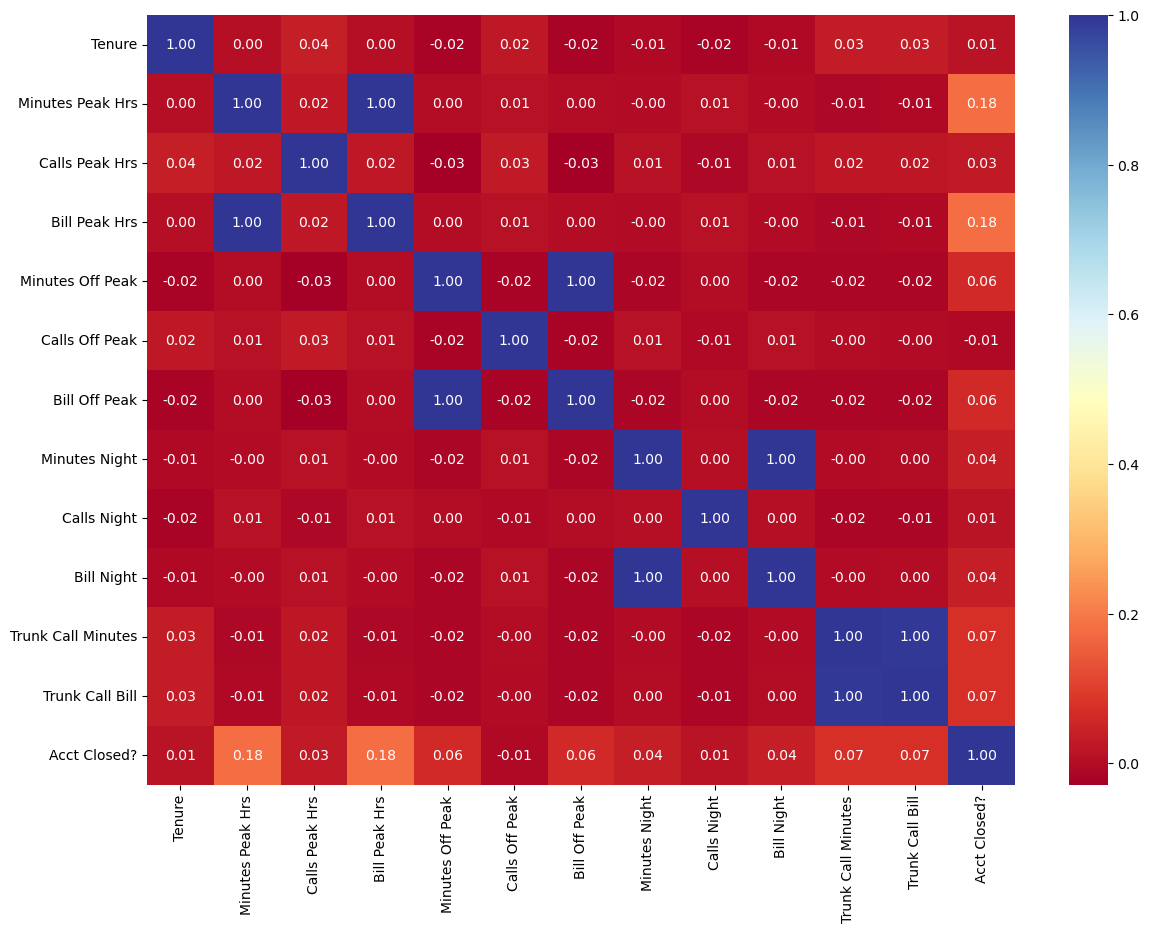

In [17]:
# Multivariate analysis
# Correlation matrix
corr_matrix=df.select_dtypes(exclude='object').corr()
size = (14, 10)
fig, ax = plt.subplots(figsize=size)
sns.heatmap(corr_matrix, annot=True, cmap="RdYlBu", fmt='.2f')
plt.show()

Here we can see that multicollinearity exists between few columns. So we will drop one at random
There is a lot features that are strongly correlated with other features. Dropping these features

In [18]:
df.drop(['Bill Peak Hrs','Bill Off Peak','Bill Night','Trunk Call Bill'],axis=1,inplace=True)
df.shape

(2666, 15)

#### Correlation with Target

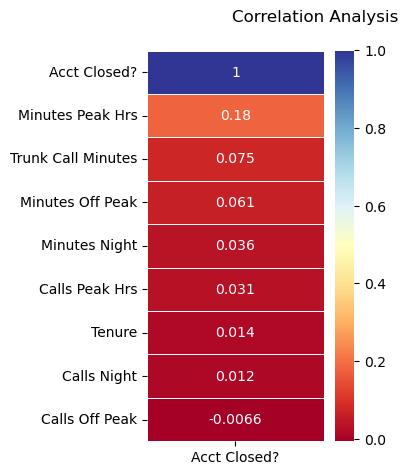

In [19]:
plt.subplot(1,2,1)

sns.heatmap(df.select_dtypes(exclude='object').corr()[['Acct Closed?']].sort_values(by='Acct Closed?', ascending=False),
                annot=True, cmap='RdYlBu', linewidths=0.5)

plt.suptitle("Correlation Analysis")
plt.tight_layout()
plt.show()

There aren't any features that are strongly correlated with the Target

Model Pipeline:
1. Splitting dataset into independent and dependent variables
2. Encoding categorical features
3. Train test split at 80:20 ratio
4. Standard Scaling the numerical features of both train and test
5. Initializing the model
6. Evaluating the model

### Basic Model

In [20]:
X = df.drop('Acct Closed?', axis=1)     # independent features
y = df['Acct Closed?']                  # target variable

# l = []
# for val in y:
#     if val == True:
#         l.append(1)
#     else:
#         l.append(0)
# y = l

In [21]:
X_enc = pd.get_dummies(X, columns=df.select_dtypes(include='object').columns.tolist(),dtype = 'int')    # Encoding categorical

### Split the dataset into training and testing sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)
print("Number of records in train set:",len(X_train))
print("Number of records in train set:",len(X_test))


Number of records in train set: 2132
Number of records in train set: 534


### Standardize the features

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initial logistic regression model

In [24]:
model1 = LogisticRegression()
model1.fit(X_train_scaled, y_train)

LogisticRegression()

In [25]:
y_pred1 = model1.predict(X_test_scaled)

### Evaluate the model

In [26]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

def model_evaluation(model,y_test,y_pred,X_train_sc,y_train):
    ### Model Accuracy - Train
    y_pred_train = model.predict(X_train_sc)
    accuracy = accuracy_score(y_train, y_pred_train)
    print("Training Accuracy of this model:", accuracy)

    ### Model Accuracy - Test
    accuracy = accuracy_score(y_test, y_pred)
    print("Testing Accuracy of this model:", accuracy)

    ### Confusion Matrix 
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [1, 0])
    cm_display.plot()
    plt.show()

    ### Report of the model:
    classification_rep = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(classification_rep)



#### Conditions for Labelling:

Training Accuracy of this model: 0.8803939962476548
Testing Accuracy of this model: 0.848314606741573

Confusion Matrix:


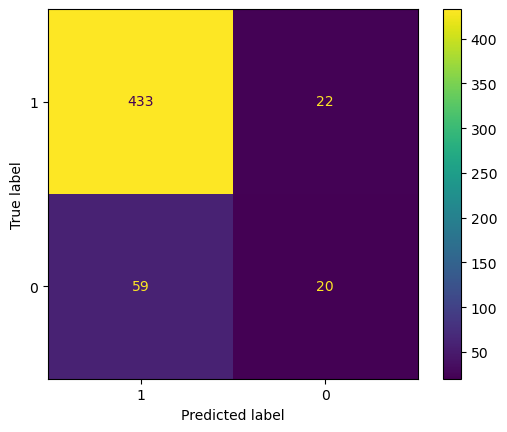


Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.95      0.91       455
        True       0.48      0.25      0.33        79

    accuracy                           0.85       534
   macro avg       0.68      0.60      0.62       534
weighted avg       0.82      0.85      0.83       534



In [27]:
model_evaluation(model1,y_test,y_pred1,X_train_scaled,y_train)

### Calculating the Area Under the Curve (AUC) and Plotting the ROC Curve

In [28]:
probabilities_1 = model1.predict_proba(X_test_scaled)[:, 1]
auc_model1 = metrics.roc_auc_score(y_test, probabilities_1)
print(f'AUC ={auc_model1}')

AUC =0.8077618583947698


The AUC of 0.8077 signifies that our model is 80.% confident that it can accuractely predict the True positives

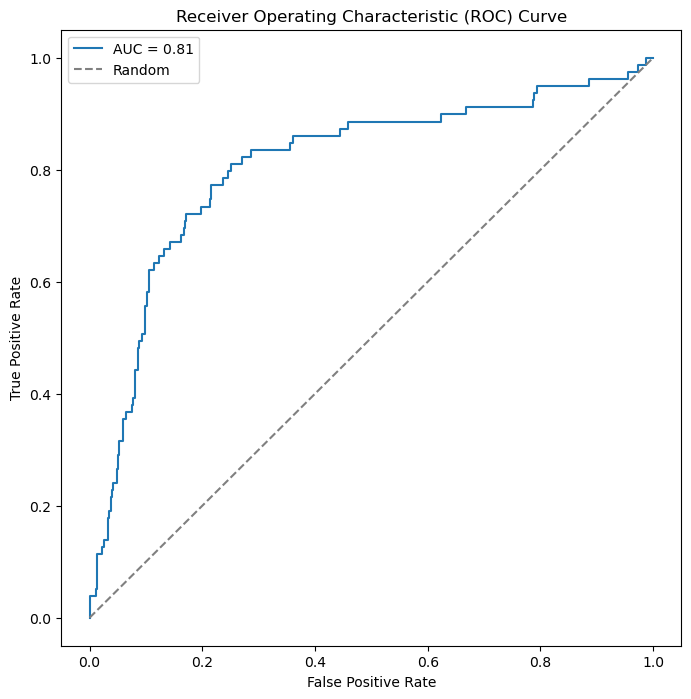

In [29]:
# Finding the probabilities
probabilities_1 = model1.predict_proba(X_test_scaled)[:, 1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, probabilities_1)
roc_auc_1 = metrics.auc(fpr1, tpr1)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f'AUC = {roc_auc_1:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Initial model performed well. But, the target class were imbalanced. Performing class imbalancing techniques below:

1. Oversampling
2. Undersampling
3. SMOTE

## Tuning -> 1 OverSampling

In [30]:
# Displaying the class distribution before oversampling
print("Class distribution before oversampling:", Counter(y))

Class distribution before oversampling: Counter({False: 2278, True: 388})


In [31]:
ros = RandomOverSampler(random_state=42)    # initiating the object

# encoding
X_enc = pd.get_dummies(X, columns=['Region', 'Tenure', 'Neighborhood', 'Trunk Calling Facility', 'Voice Messaging'],dtype='int')

X_ros, y_ros = ros.fit_resample(X_enc, y)     # fitting encoded data and resampled data

print("Class distribution after oversampling:", Counter(y_ros))

Class distribution after oversampling: Counter({False: 2278, True: 2278})


In [32]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

In [33]:
#Scaling the encoded dataset
scaler = StandardScaler()
X_train_ros_scaled = scaler.fit_transform(X_train_ros)
X_test_ros_scaled = scaler.transform(X_test_ros)

#Fitting the model
model2 = LogisticRegression()
model2.fit(X_train_ros_scaled, y_train_ros)

#Predicting the values
y_pred2 = model2.predict(X_test_ros_scaled)


Training Accuracy of this model: 0.8282107574094402
Testing Accuracy of this model: 0.7807017543859649

Confusion Matrix:


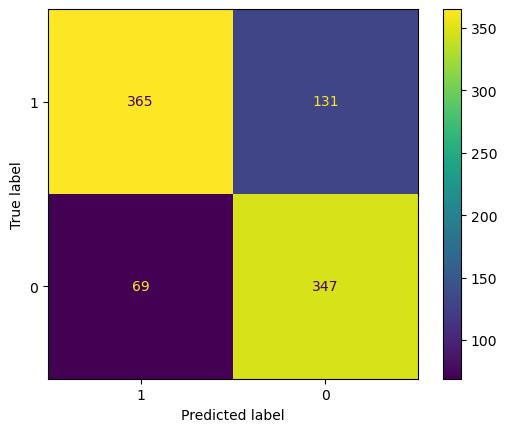


Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.74      0.78       496
        True       0.73      0.83      0.78       416

    accuracy                           0.78       912
   macro avg       0.78      0.79      0.78       912
weighted avg       0.79      0.78      0.78       912



In [34]:
model_evaluation(model2, y_test_ros, y_pred2, X_train_ros_scaled,y_train_ros)

### Calculating the Area Under the Curve (AUC) and Plotting the ROC Curve

In [35]:
probabilities_2 = model2.predict_proba(X_test_ros_scaled)[:, 1]
auc_model2 = metrics.roc_auc_score(y_test_ros, probabilities_2)
print(f'AUC ={auc_model2}')

AUC =0.8403671681141438


The AUC of 0.8403 signifies that our model is 84% confident that it can accuractely predict the True positives

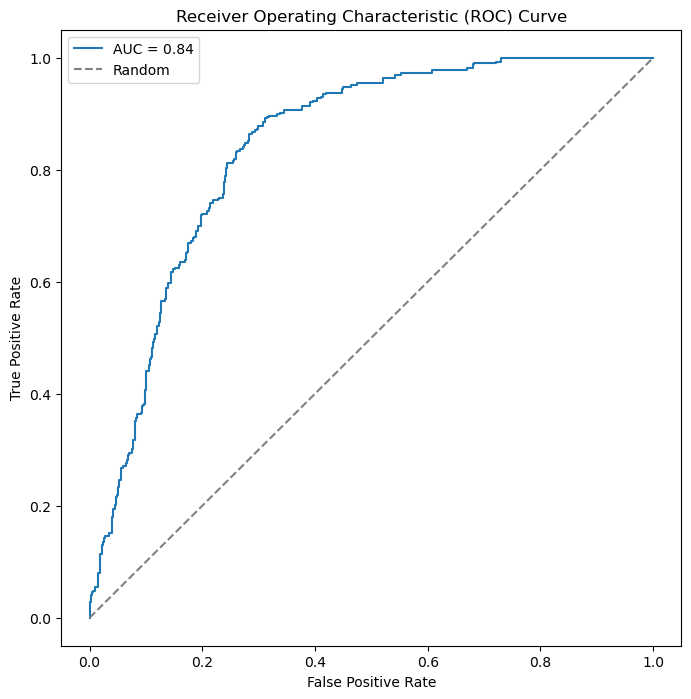

In [36]:
#Finding the probabilities of the second model and calculating the false and true positive rates
probabilities_2 = model2.predict_proba(X_test_ros_scaled)[:, 1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test_ros, probabilities_2)
roc_auc_2 = metrics.auc(fpr2, tpr2)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr2, tpr2, label=f'AUC = {roc_auc_2:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Tuning -> 2 Undersampling

In [37]:
# Display the class distribution before oversampling
print("Class distribution before undersampling:", Counter(y))

Class distribution before undersampling: Counter({False: 2278, True: 388})


In [38]:
# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

In [39]:
X_enc = pd.get_dummies(X, columns=['Region', 'Tenure', 'Neighborhood', 'Trunk Calling Facility', 'Voice Messaging'])
# Fit and apply the sampler to the data
X_rus, y_rus = rus.fit_resample(X_enc, y)

In [40]:
print("Class distribution after oversampling:", Counter(y_rus))

Class distribution after oversampling: Counter({False: 388, True: 388})


In [41]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)

In [42]:
#Scaling the data
scaler = StandardScaler()
X_train_rus_scaled = scaler.fit_transform(X_train_rus)
X_test_rus_scaled = scaler.transform(X_test_rus)

In [43]:
#Fitting the model
model3 = LogisticRegression()
model3.fit(X_train_rus_scaled, y_train_rus)

#Predicting the values
y_pred3 = model3.predict(X_test_rus_scaled)

Training Accuracy of this model: 0.8758064516129033
Testing Accuracy of this model: 0.6730769230769231

Confusion Matrix:


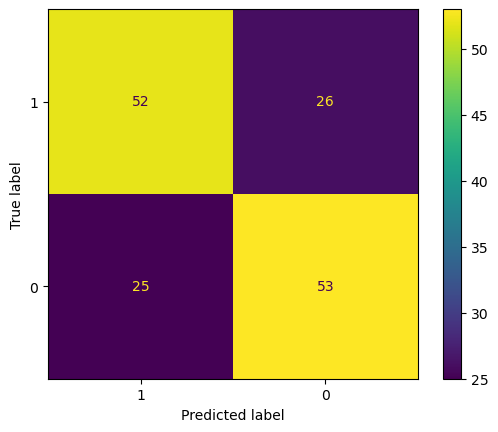


Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.67      0.67        78
        True       0.67      0.68      0.68        78

    accuracy                           0.67       156
   macro avg       0.67      0.67      0.67       156
weighted avg       0.67      0.67      0.67       156



In [44]:
model_evaluation(model3,y_test_rus,y_pred3,X_train_rus_scaled,y_train_rus)

### Calculating the Area Under the Curve (AUC) and Plotting the ROC Curve

In [45]:
probabilities_3 = model3.predict_proba(X_test_rus_scaled)[:, 1]
auc_model3 = metrics.roc_auc_score(y_test_rus, probabilities_3)
print(f'AUC ={auc_model3}')

AUC =0.7077580539119002


The AUC of 0.7077 signifies that our model is 70% confident that it can accuractely predict the True positives

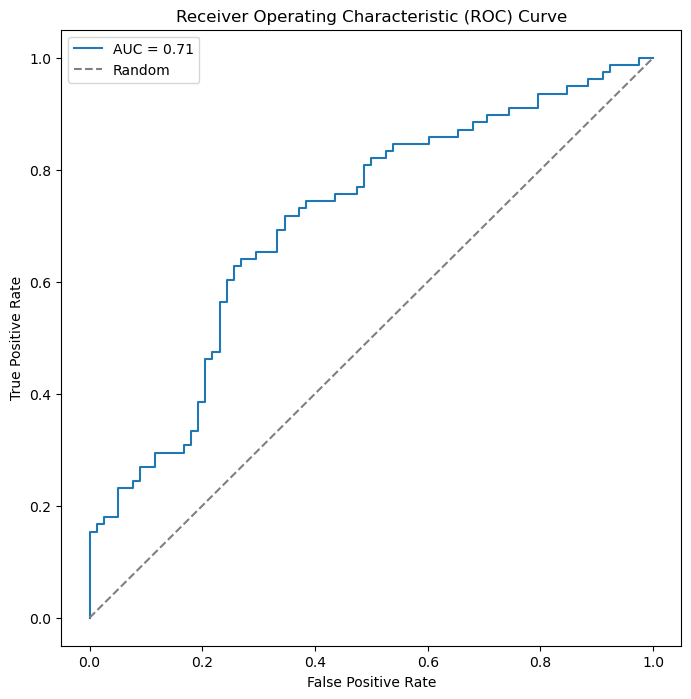

In [46]:
#Finding the probabilities of the third model and calculating the false and true positive rates
probabilities_3 = model3.predict_proba(X_test_rus_scaled)[:, 1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test_rus, probabilities_3)
roc_auc_3 = metrics.auc(fpr3, tpr3)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr3, tpr3, label=f'AUC = {roc_auc_3:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Tuning 3 -> SMOTE Analysis

In [47]:
# Display the class distribution before oversampling
print("Class distribution before undersampling:", Counter(y))

Class distribution before undersampling: Counter({False: 2278, True: 388})


In [48]:
smote = SMOTE(random_state=42)

In [49]:
X_enc = pd.get_dummies(X, columns=['Region', 'Tenure', 'Neighborhood', 'Trunk Calling Facility', 'Voice Messaging'],dtype='int')
X_smt, y_smt= smote.fit_resample(X_enc, y)

In [50]:
X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(X_smt, y_smt, test_size=0.2, random_state=42)

#Scaling
scaler = StandardScaler()
X_train_smt_scaled = scaler.fit_transform(X_train_smt)
X_test_smt_scaled = scaler.transform(X_test_smt)

#Fitting the model
model4 = LogisticRegression()
model4.fit(X_train_smt_scaled, y_train_smt)

#Predicting the values
y_pred4 = model4.predict(X_test_smt_scaled)


Training Accuracy of this model: 0.9385290889132821
Testing Accuracy of this model: 0.9067982456140351

Confusion Matrix:


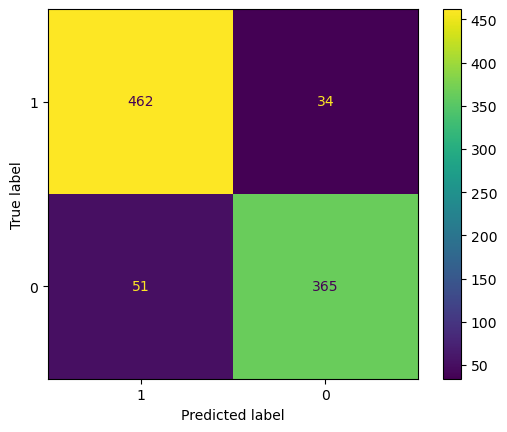


Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.93      0.92       496
        True       0.91      0.88      0.90       416

    accuracy                           0.91       912
   macro avg       0.91      0.90      0.91       912
weighted avg       0.91      0.91      0.91       912



In [51]:
model_evaluation(model4,y_test_smt,y_pred4,X_train_smt_scaled,y_train_smt)

### Calculating the Area Under the Curve (AUC) and Plotting the ROC Curve

In [52]:
probabilities_4 = model4.predict_proba(X_test_smt_scaled)[:, 1]
auc_model4 = metrics.roc_auc_score(y_test_smt, probabilities_4)
print(f'AUC ={auc_model4}')

AUC =0.9482930753722085


The AUC of 0.9482 signifies that our model is 94.82% confident that it can accuractely predict the True positives

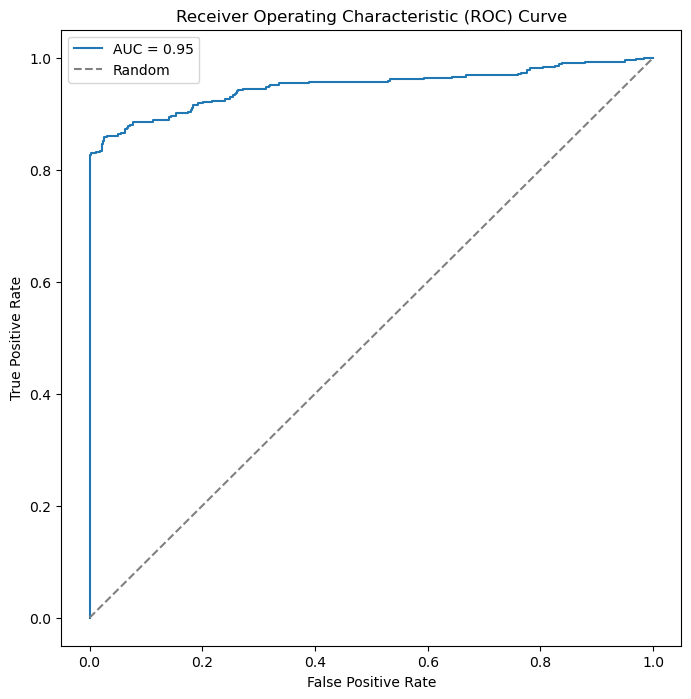

In [53]:
#Finding the probabilities of the fourth model and calculating the false and true positive rates
probabilities_4 = model4.predict_proba(X_test_smt_scaled)[:, 1]
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test_smt, probabilities_4)
roc_auc_4 = metrics.auc(fpr4, tpr4)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr4, tpr4, label=f'AUC = {roc_auc_4:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Tuning 4 -> Ridge and Lasso Regularization

In [54]:
###################################
# Ridge Regularization
# Splitting dataset intro train and test 
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_smt, y_smt, test_size=0.2, random_state=42)

# Scaling dataset
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

In [55]:
# Train logistic regression with ridge regularization
model5_rdg = LogisticRegression(penalty='l2',solver='liblinear',C=0.07)
model5_rdg.fit(X_train_reg_scaled, y_train_reg)

# Make predictions on the test set
y_pred5_rdg = model5_rdg.predict(X_test_reg_scaled)


Training Accuracy of this model: 0.9357848518111965
Testing Accuracy of this model: 0.9035087719298246

Confusion Matrix:


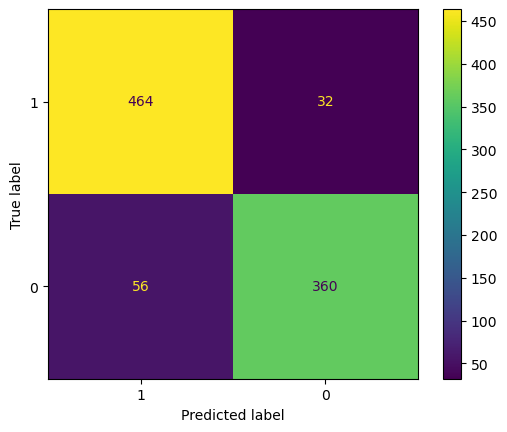


Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.94      0.91       496
        True       0.92      0.87      0.89       416

    accuracy                           0.90       912
   macro avg       0.91      0.90      0.90       912
weighted avg       0.90      0.90      0.90       912



In [56]:
model_evaluation(model5_rdg,y_test_reg,y_pred5_rdg,X_train_reg_scaled,y_train_reg)

### Calculating the Area Under the Curve (AUC) and Plotting the ROC Curve

In [57]:
probabilities_5_rdg = model5_rdg.predict_proba(X_test_reg_scaled)[:, 1]
auc_model5_rdg = metrics.roc_auc_score(y_test_reg, probabilities_5_rdg)
print(f'AUC ={auc_model5_rdg}')

AUC =0.9537695797146402


The AUC of 0.9537 signifies that our model is 95.37% confident that it can accuractely predict the True positives

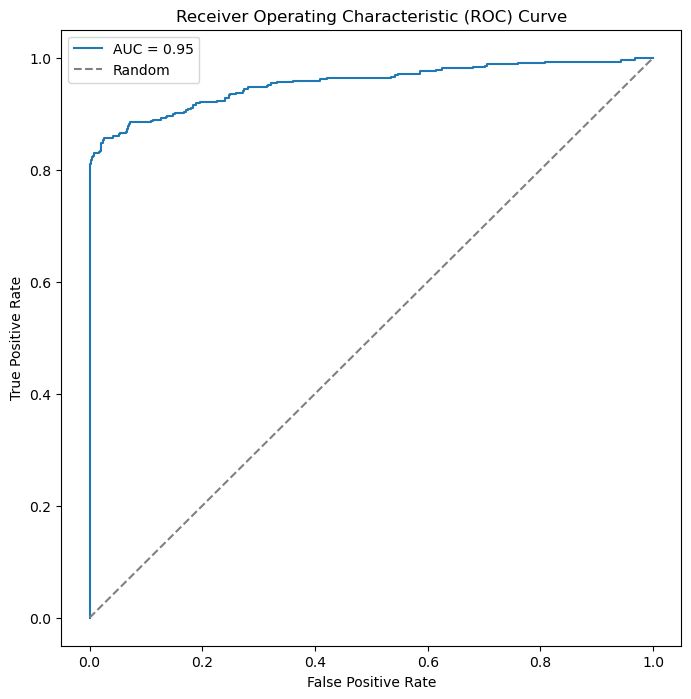

In [58]:
#Finding the probabilities of the fifth model and calculating the false and true positive rates
probabilities_5_rdg = model5_rdg.predict_proba(X_test_reg_scaled)[:, 1]
fpr5_rdg, tpr5_rdg, thresholds5_rdg = metrics.roc_curve(y_test_reg, probabilities_5_rdg)
roc_auc_5_rdg = metrics.auc(fpr5_rdg, tpr5_rdg)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr5_rdg, tpr5_rdg, label=f'AUC = {roc_auc_5_rdg:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [59]:
###################################
# Lasso Regularization
# Evaluate the model
# Train logistic regression with ridge regularization
model5_las = LogisticRegression(penalty='l1',solver='liblinear',C=0.02)
model5_las.fit(X_train_reg_scaled, y_train_reg)

# Make predictions on the test set
y_pred5_las = model5_las.predict(X_test_reg_scaled)


Training Accuracy of this model: 0.8773326015367727
Testing Accuracy of this model: 0.8771929824561403

Confusion Matrix:


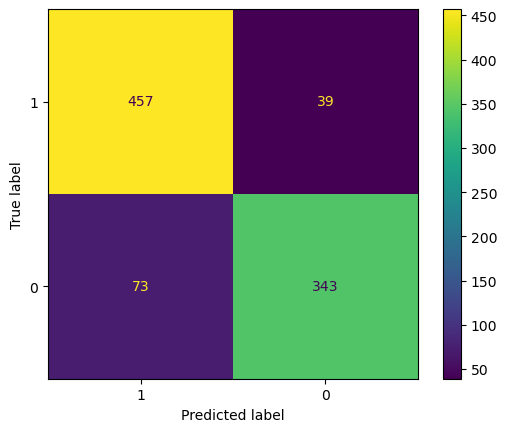


Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.92      0.89       496
        True       0.90      0.82      0.86       416

    accuracy                           0.88       912
   macro avg       0.88      0.87      0.88       912
weighted avg       0.88      0.88      0.88       912



In [60]:
model_evaluation(model5_las,y_test_reg,y_pred5_las,X_train_reg_scaled,y_train_reg)

### Calculating the Area Under the Curve (AUC) and Plotting the ROC Curve

In [61]:
probabilities_5_las = model5_las.predict_proba(X_test_reg_scaled)[:, 1]
auc_model5_las = metrics.roc_auc_score(y_test_reg, probabilities_5_las)
print(f'AUC ={auc_model5_las}')

AUC =0.9512639578163772


The AUC of 0.9512 signifies that our model is 95.12% confident that it can accuractely predict the True positives

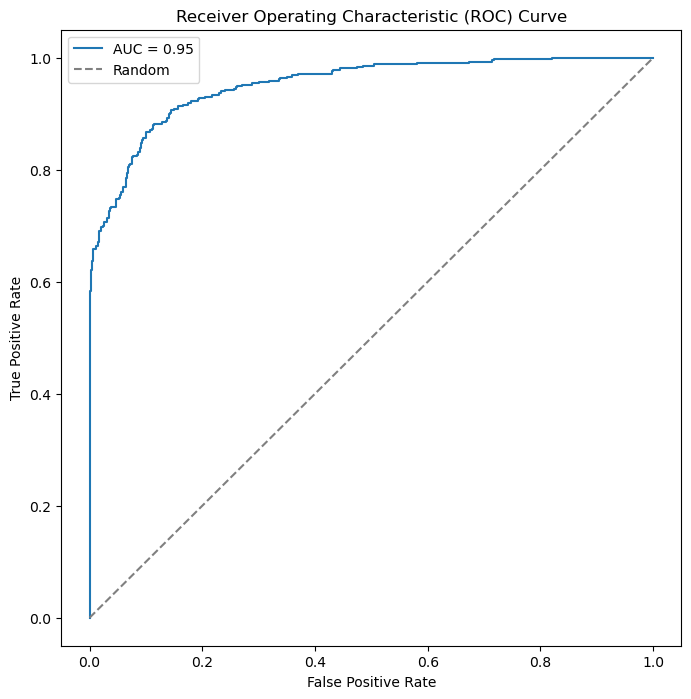

In [62]:
#Finding the probabilities of the fifth model and calculating the false and true positive rates
probabilities_5_las = model5_las.predict_proba(X_test_reg_scaled)[:, 1]
fpr5_las, tpr5_las, thresholds5_las = metrics.roc_curve(y_test_reg, probabilities_5_las)
roc_auc_5_las = metrics.auc(fpr5_las, tpr5_las)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr5_las, tpr5_las, label=f'AUC = {roc_auc_5_las:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### Ridge Regularization is providing a better accuracy than Lasso. But to further identify which is performing better, we will use grid search cv to obtain the optimal value

##### With ridge and lasso regularization we are not seeing that much difference as compared to Model 4 where we did using smote analysis. This could be due to not optimal value of lamda. Here, c = 1/lambda. So, higher the value of c lower the regularization hyperparameter. We will be doing a grid search CV to obtain the optimal value.

### Tuning 5 -> Grid Search CV

In [63]:
# max_iter_values = np.arange(50,501,50)
param_grid = {'C': [0.02,0.03,0.05,0.06,0.07,0.09,0.1,0.15,0.2,0.5,0.75,0.9],
              'penalty':['l2','l1'],
              'solver':['liblinear']}

grid_search = GridSearchCV(model4, param_grid, cv = 2,scoring='accuracy',verbose=1,return_train_score=True)
grid_search.fit(X_train_smt_scaled, y_train_smt) #Fit the GridSearchCV object to the training data
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_ # Get the Best Parameter
test_accuracy = best_model.score(X_test_smt_scaled, y_test_smt) #Evaluate on Test Set
print(test_accuracy)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


0.9078947368421053


In [64]:
best_params

{'C': 0.15, 'penalty': 'l1', 'solver': 'liblinear'}

#### With the optimal parameters shown above, we are building another regularization model to see if there is any improvement in the metrics:

In [65]:
### Model6
# Train logistic regression with new lambda from grid search
model6_las = LogisticRegression(penalty='l1',C=0.15,solver='liblinear')
model6_las.fit(X_train_reg_scaled, y_train_reg)

# Make predictions on the test set
y_pred6_las = model6_las.predict(X_test_reg_scaled)

Training Accuracy of this model: 0.9327661909989023
Testing Accuracy of this model: 0.9078947368421053

Confusion Matrix:


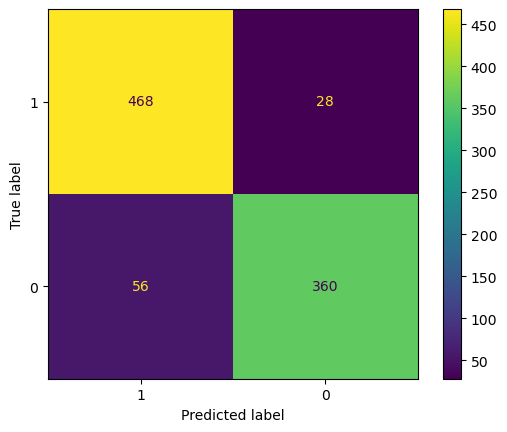


Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.94      0.92       496
        True       0.93      0.87      0.90       416

    accuracy                           0.91       912
   macro avg       0.91      0.90      0.91       912
weighted avg       0.91      0.91      0.91       912



In [66]:
model_evaluation(model6_las,y_test_reg,y_pred6_las,X_train_reg_scaled,y_train_reg)

### Calculating the Area Under the Curve (AUC) and Plotting the ROC Curve

In [67]:
probabilities_6_las = model6_las.predict_proba(X_test_reg_scaled)[:, 1]
auc_model6_las = metrics.roc_auc_score(y_test_reg, probabilities_6_las)
print(f'AUC ={auc_model6_las}')

AUC =0.959372092121588


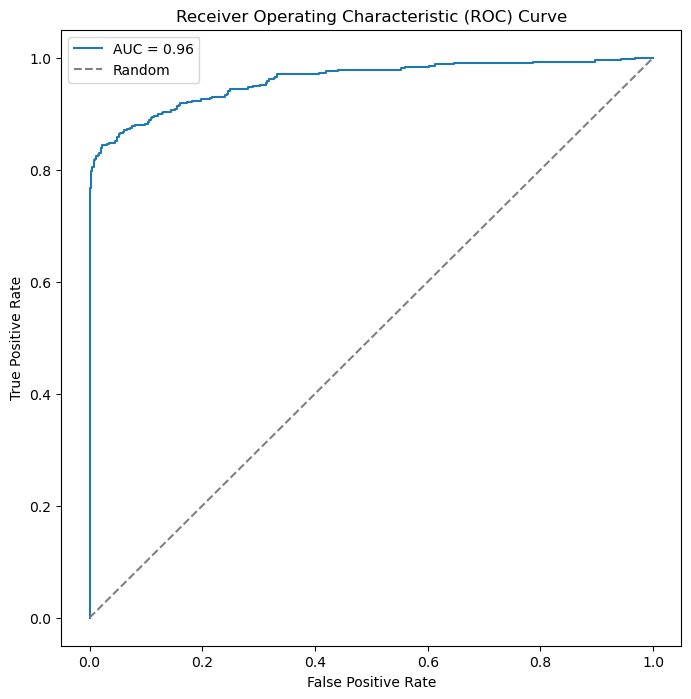

In [68]:
# Assuming clf is your trained classifier
probabilities_6_las= model6_las.predict_proba(X_test_reg_scaled)[:, 1]
fpr6_las, tpr6_las, thresholds6_las = metrics.roc_curve(y_test_reg, probabilities_6_las)
roc_auc_6_las = metrics.auc(fpr6_las, tpr6_las)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr6_las, tpr6_las, label=f'AUC = {roc_auc_6_las:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

 After using the optimal hyperparameters, we can conclude that regularizing the data is not making a discernable change since
since there was just a 0.30% increase in the accuracy. However, after utilizing the optimal hyperparamters that we got from GridSearch, we can 
see an increase in the AUC score. This signfies that our optimal values are providing a better performance than before. The model built above is the final model of our analysis. Trying out K fold validation to build confidence in our final model accuracy.

### 10 Fold Cross Validation

In [69]:
# Standardize the features
scaler = StandardScaler()
X_scaled_kcv = scaler.fit_transform(X_enc)

In [70]:
# Create a logistic regression model
model7_10kcv = LogisticRegression(solver='liblinear',C=0.15,penalty='l1') #Considering the most optimum lambda

In [71]:
# Define the number of folds for cross-validation (10-fold)
num_folds = 10

# Create a KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [72]:
# Perform cross-validation and evaluate the model
model7_kcv = cross_val_score(model7_10kcv, X_scaled_kcv, y, cv=kf, scoring='accuracy')

In [73]:
# Print the accuracy for each fold and the average accuracy
for fold, accuracy in enumerate(model7_kcv, start=1):
    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

Fold 1: Accuracy = 0.8277
Fold 2: Accuracy = 0.8464
Fold 3: Accuracy = 0.8614
Fold 4: Accuracy = 0.8727
Fold 5: Accuracy = 0.8315
Fold 6: Accuracy = 0.8427
Fold 7: Accuracy = 0.8985
Fold 8: Accuracy = 0.8835
Fold 9: Accuracy = 0.8346
Fold 10: Accuracy = 0.8383


In [74]:
average_accuracy = np.mean(model7_kcv)
print(f"\nAverage Accuracy across {num_folds}-fold Cross-Validation: {average_accuracy:.4f}")


Average Accuracy across 10-fold Cross-Validation: 0.8537


From the 10 fold cross validation, we can see that the accuracy we get for every model test is nearly the same around 85%. This tells us that the model is consistent in its predictions as the variation in the accuracy is low. The training and testing datasets used for every fold of the model does not vary much leading to similar performance.

#### Conclusion

This analysis was done to obtain the best fit model on this dataset. The grid search selected the optimal hyperparamters for the penalty, solver and c value from the provided values. On using these parameters we observed the model has improved. To build confidence in the result of ths model, a 10 fold was done that gave us an average accuracy of 85%. 


This model predicts whether an account of a current customer will continue for the next billing cycle. It uses features like the location of the customer, relationship of the customer with the company, communication activity of the customer on their current plan as well as any complaints they might have submitted. 85% of the time the model is accurate in predicting whether a certain customer with the above traits would close their account or not.

<center><h1> END </h1></center>